In [19]:
%load_ext autoreload
%autoreload 2

import pynwb
import numpy as np

# pip install python-intervals, *NOT* pip install intervals
import intervals as iv

import query_helpers as qu

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker


plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data import parameters

In [2]:
animday = 'Bon04'
nwb_filename = './' + animday + '_test.nwb'

### Read NWB file

In [3]:
print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()

posix_offset = nwbf.session_start_time.timestamp()

Loading file: ./Bon04_test.nwb


### Collect spike times and observation intervals

In [4]:
# Select cluster 
# TODO select cluster by metadata
cluster_id = 30

# Get cluster name
clname_idx = nwbf.units.colnames.index('cluster_name')
cluster_name = animday + ' ' + nwbf.units.columns[clname_idx][cluster_id]
print('Cluster name = ' + cluster_name)

# Get spike times
spikes_t = nwbf.modules['Spike Data']['UnitTimes'].get_unit_spike_times(cluster_id)
print('# of spikes = %d' % spikes_t.size)
print('Time of 1st/last spike (s): %0.4f / %0.4f \n' % (spikes_t[0], spikes_t[-1]))

# Get spike observation intervals
obsint_idx = nwbf.units.colnames.index('obs_intervals')
obs_IntervalSeries = nwbf.units.columns[obsint_idx][cluster_id] # returns IntervalSeries
obs_intervals = qu.intervals_from_IntervalSeries(obs_IntervalSeries)

    
print('# of intervals = %d' % len(obs_intervals))
print('Spike Observation Intervals (s): ')
print(obs_intervals)
print()

assert qu.times_in_intervals(spikes_t, obs_intervals), 'Spike times found outside of observation intervals'

Cluster name = Bon04 d4 t11 c4
# of spikes = 2192
Time of 1st/last spike (s): 1136146715.9655 / 1136154946.9964 

# of intervals = 7
Spike Observation Intervals (s): 
[1136146605.0,1136147943.0] | [1136148061.0,1136149005.0] | [1136149083.0,1136150027.0] | [1136150164.0,1136151101.0] | [1136151178.0,1136152411.0] | [1136152994.0,1136153926.0] | [1136154113.0,1136154948.0]



### Do some sample Time Queries

In [7]:
# pandas uses nanoseconds (covers range to 2262 AD), but Python datetimes are in microseconds,
# which is all we need, precision-wise. Hmmm...

# def timestamps_to_datetime64(timestamps):
#     '''Convert POSIX timestamps (in fractional seconds), to numpy.datetime64[ns]'''
#     return(np.array(int(timestamps*1e9),'datetime64[ns]'))

# def h5_timestamps_to_datetime64(timestamps_h5):
#     '''Convert POSIX timestamps (in fractional seconds), to numpy.datetime64[ns]'''
#     return(timestamps_to_datetime64(np.array(timestamps_h5)))
    
# Time queries
tqs = []
# (query, short_label, long_label, mockup answers)
# Get spikes from epoch 1
tqs.append((obs_intervals[0], 'A', 'Full epoch'))
# Get spikes from all sleep epochs
tqs.append((obs_intervals[0] | obs_intervals[2] | obs_intervals[4] | obs_intervals[6], 'B', 'Multiple epochs'))
# Get spikes from valid interval with no spiking
tqs.append((iv.closed(5900+posix_offset, 6200+posix_offset), 'C', 'Full overlap, no spikes'))
# partial overlap between query and obs_int
tqs.append((iv.closed(6600+posix_offset, 7050+posix_offset), 'D', 'Partial overlap'))
# non-overlap between query and obs_int
tqs.append((iv.closed(9500+posix_offset, 9900+posix_offset), 'E', 'No overlap'))


# TODO: harmonize timestamps across speed (POSIX time?) and spikes/obs_ints. During import.
speed = nwbf.modules['Behavior']['Speed']['Speed d4 e4']
speed_ts = speed.timestamps.value # convert from HDF5 dataset
# speed_ts = h5_timestamps_to_datetime64(speed.timestamps) #np.array(speed.timestamps) # convert from HDF5 dataset
speed_data = np.array(speed.data)

speed_threshold_fn = lambda x: x > 0.01 # m/s
speed_gt_intervals = qu.intervals_from_continuous(speed_data, speed_ts, speed_threshold_fn)
speed_gt_ep3_intervals = speed_gt_intervals & obs_intervals[2] # limit to run epochs

tqs.append((speed_gt_intervals, 'F', 'Complex behavioral query'))

# calculate responses
rs = []
for tq in tqs:
    tq_intervals = tq[0]
    r_intervals = tq_intervals & obs_intervals # intersection operator!
#     print(iv.to_string(r_intervals))
    r_spikes = qu.times_in_intervals(spikes_t,r_intervals)
    print(len(r_spikes))
    rs.append((r_intervals, r_spikes))
    

47
337
0
10
0
389


### Plot spiking and some sample Time Queries & Responses

1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6
1136151348.6


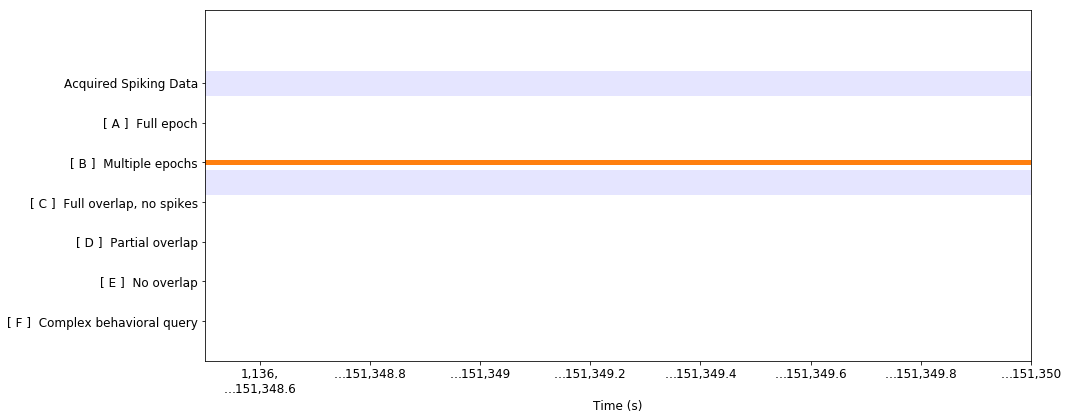

In [61]:
fig1 = plt.figure(1, figsize=(15,6))
ax1 = fig1.add_subplot(1,1,1)
labels = []
labels.append((1,'Acquired Spiking Data'))

ypos = 1

int_h, times_h = qu.plot_pointprocess(obs_intervals, spikes_t, axis=ax1)

y_offset = -5
spacing = 6
cmap = plt.get_cmap("tab10")
plots_h = []
for i, tq in enumerate(tqs):
    tq_intervals = qu.array_from_intervals(tq[0]).T
    ypos = y_offset-i*spacing
    labels.append((ypos, '[ %s ]  %s' % (tq[1], tq[2])))
    line_h = ax1.plot(tq_intervals,np.full(tq_intervals.shape, ypos), 
                        color=cmap(i), linewidth=5, marker='')
    ax1.vlines(tq_intervals, ypos, -1, color=cmap(i), linestyle='--', alpha=0.2)
    plots_h.append(line_h[0])
    
    # plot query response
    r_intervals = rs[i][0]
    r_spikes = np.array(rs[i][1])

    int_h, times_h = qu.plot_pointprocess(r_intervals, r_spikes, ypos=ypos-3, axis=ax1)

ax1.set_ylim([ypos-spacing,2*spacing])
ax1.set_yticks([l[0] for l in labels])
ax1.set_yticklabels([l[1] for l in labels])

xtick_locator = mticker.AutoLocator()
xtick_formatter = mticker.FuncFormatter(qu.fmt_truncate_posix)

ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)

ax1.set_xlabel('Time (s)')

ax1.set_xlim([x+1136e6 for x in [151348.5, 151350]])


plt.tight_layout()
fig1.savefig('./spike_timequeries.png', dpi=200)

# ax1.set_xlim((4000,4100))
None

### Compute average firing rate across intervals

In [ ]:
def mean_firing_rate(spikes_t, obs_intervals):
    assert qu.times_in_intervals(spikes_t, obs_intervals), 'Spike times found outside of observation intervals'
    obs_intervals = qu.array_from_intervals(obs_intervals)
    return spikes_t.size / np.diff(obs_intervals, axis=1).sum()

fr_mean_Hz = mean_firing_rate(spikes_t, obs_intervals)
print('Mean firing rate of cluster %s: %0.3f Hz' % (cluster_name, fr_mean_Hz) )

In [ ]:
io.close()